In [1]:
!nvidia-smi

Thu Oct 26 18:36:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0 Off |                  N/A |
| 23%   21C    P8     8W / 250W |  11175MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:0A:00.0 Off |                  N/A |
| 23%   

# Autoencoder network with HCP Dataset

This notebook illustrates the use of the autoencoder in MONAI for the purpose of functional connectivity matrices.

## Setup imports

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
import time
from sklearn.model_selection import train_test_split
import pylab as pl
from IPython import display
import logging
import os
import shutil
import sys
import torch.nn as nn
import tempfile
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import torch
from urllib.request import urlretrieve
import gzip
from PIL import Image
import pathlib
from pathlib import Path
import pandas as pd
from monai.networks.nets import AutoEncoder
import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.networks.nets import VarAutoEncoder
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    ScaleIntensityD,
    EnsureTypeD,
)
from monai.utils import set_determinism

In [3]:
SEED = 1380
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

## Setup data directory

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp41vo0a21


In [5]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
set_determinism(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Get the data

In [6]:
data_directory = "Data/hcp_rest_and_motor/hcp_rest_and_motor/"

In [7]:
os.listdir(data_directory)

['182739_tfMRI_MOTOR_LR.csv',
 '180230_rfMRI_REST1_LR.csv',
 '285446_rfMRI_REST1_LR.csv',
 '275645_tfMRI_MOTOR_LR.csv',
 '112314_rfMRI_REST1_LR.csv',
 '138231_rfMRI_REST1_LR.csv',
 '158540_tfMRI_MOTOR_LR.csv',
 '135124_tfMRI_MOTOR_LR.csv',
 '153934_tfMRI_MOTOR_LR.csv',
 '134324_tfMRI_MOTOR_LR.csv',
 '118932_rfMRI_REST1_LR.csv',
 '393550_tfMRI_MOTOR_LR.csv',
 '145834_rfMRI_REST1_LR.csv',
 '148840_tfMRI_MOTOR_LR.csv',
 '724446_rfMRI_REST1_LR.csv',
 '692964_rfMRI_REST1_LR.csv',
 '103111_rfMRI_REST1_LR.csv',
 '558960_tfMRI_MOTOR_LR.csv',
 '151930_tfMRI_MOTOR_LR.csv',
 '130114_tfMRI_MOTOR_LR.csv',
 '114217_tfMRI_MOTOR_LR.csv',
 '250427_tfMRI_MOTOR_LR.csv',
 '304020_rfMRI_REST1_LR.csv',
 '376247_tfMRI_MOTOR_LR.csv',
 '151728_rfMRI_REST1_LR.csv',
 '436845_rfMRI_REST1_LR.csv',
 '108525_rfMRI_REST1_LR.csv',
 '108121_tfMRI_MOTOR_LR.csv',
 '187143_tfMRI_MOTOR_LR.csv',
 '180533_rfMRI_REST1_LR.csv',
 '122822_rfMRI_REST1_LR.csv',
 '224022_tfMRI_MOTOR_LR.csv',
 '545345_rfMRI_REST1_LR.csv',
 '436239_r

**1.1 Plot sample matrices**

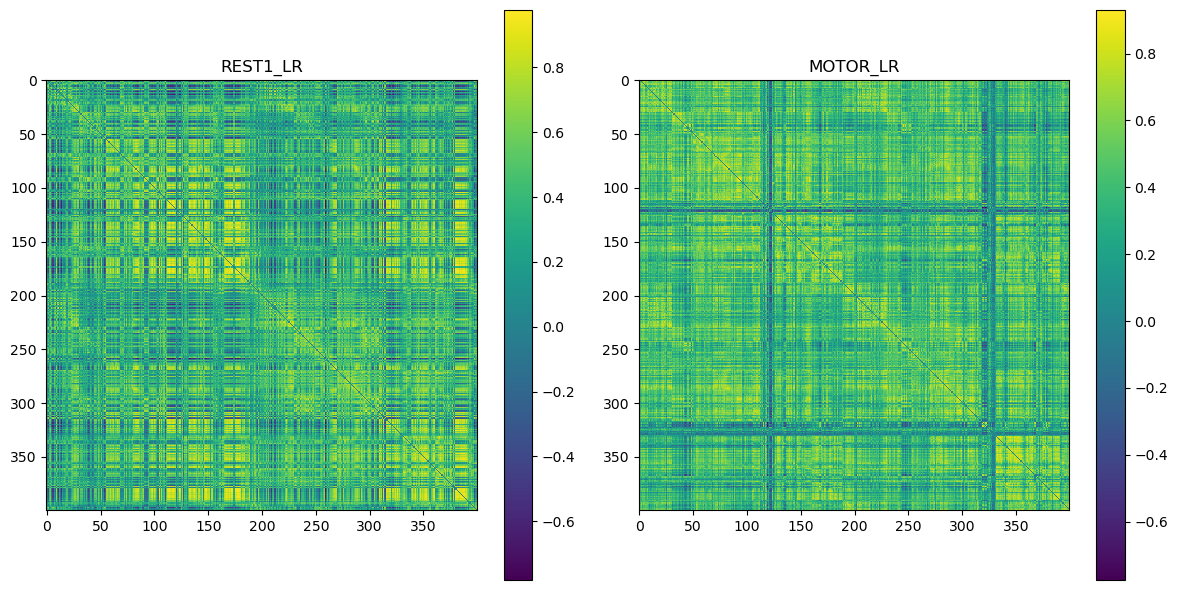

In [8]:
rest_data = np.loadtxt("Data/hcp_rest_and_motor/hcp_rest_and_motor/580751_rfMRI_REST1_LR.csv", delimiter=",", skiprows=1)
motor_data = np.loadtxt("Data/hcp_rest_and_motor/hcp_rest_and_motor/580751_tfMRI_MOTOR_LR.csv", delimiter=",", skiprows=1)

plt.figure(figsize=(12, 6)) 

# Heatmap for 580751_rfMRI_REST1_LR.csv
plt.subplot(1, 2, 1)
plt.imshow(rest_data, cmap='viridis', interpolation='nearest')
plt.title("REST1_LR")
plt.colorbar()

# Heatmap for 580751_rfMRI_MOTOR_LR.csv
plt.subplot(1, 2, 2)
plt.imshow(motor_data, cmap='viridis', interpolation='nearest')
plt.title("MOTOR_LR")
plt.colorbar()

plt.tight_layout()  
plt.show()

**1.2. Create class to load our FC matrices**

In [9]:
class FMRIConnectivityDataset(Dataset):
    def __init__(self, data_directory, ids, transform=None):
        self.transform = transform
        self.data = [] 

        for subject_id in ids:
            rest_file_path = os.path.join(data_directory, f"{subject_id}_rfMRI_REST1_LR.csv")
            motor_file_path = os.path.join(data_directory, f"{subject_id}_tfMRI_MOTOR_LR.csv")

            if os.path.exists(rest_file_path) and os.path.exists(motor_file_path):
                rest_data = pd.read_csv(rest_file_path)
                motor_data = pd.read_csv(motor_file_path)

                self.data.append((subject_id, rest_data.values, motor_data.values))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subject_id, rest_fMRI_matrix, motor_task_fMRI_matrix = self.data[idx]

        data_dict = {
            "subject_id": subject_id,
            "rest_fMRI_data": torch.FloatTensor(rest_fMRI_matrix[np.newaxis,:,:]),
            "motor_task_fMRI_data": torch.FloatTensor(motor_task_fMRI_matrix[np.newaxis,:,:])
        }

        return data_dict

**1.3. Split data into train, test, val**

In [10]:
# data_directory = "Data/hcp_rest_and_motor/hcp_rest_and_motor/"

# # List all files in the data directory
# file_names = [f for f in os.listdir(data_directory) if f.endswith(".csv")]

# # Split the file names to extract the subject IDs
# file_ids = [file.split('_')[0] for file in file_names]

# # Define the split ratios (60% train, 20% validation, 20% test)
# train_ratio = 0.6
# validation_ratio = 0.2
# test_ratio = 0.2

# # Split the subject IDs into train, validation, and test sets
# train_ids, test_and_val_ids = train_test_split(file_ids, test_size=test_ratio, random_state=1380)
# validation_ids, test_ids = train_test_split(test_and_val_ids, test_size=0.5, random_state=1380)

# # Create datasets for the training, validation, and test sets
# train_dataset = FMRIConnectivityDataset(data_directory, train_ids)
# validation_dataset = FMRIConnectivityDataset(data_directory, validation_ids)
# test_dataset = FMRIConnectivityDataset(data_directory, test_ids)

# # Dataloaders for training, validation, and test sets
# batch_size = 21
# train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
# test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# Set your data directory
data_directory = "Data/hcp_rest_and_motor/hcp_rest_and_motor/"

# List all files in the data directory and extract subject IDs
file_names = [f for f in os.listdir(data_directory) if f.endswith(".csv")]
file_ids = [file.split('_')[0] for file in file_names]

# Define the split ratios (60% train, 40% test)
train_ratio = 0.6
test_ratio = 0.4

# Split the subject IDs into train and test sets while ensuring no intersection
train_ids, test_ids = train_test_split(file_ids, test_size=test_ratio, random_state=1380)

# Create datasets for the training and test sets using your custom dataset module
train_dataset = FMRIConnectivityDataset(data_directory, train_ids)
test_dataset = FMRIConnectivityDataset(data_directory, test_ids)

# Define batch size
batch_size = 21

# Create data loaders for training and test sets
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# VarAutoEncoder

In [11]:
from __future__ import annotations

from collections.abc import Sequence

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

from monai.networks.layers.convutils import calculate_out_shape, same_padding
from monai.networks.layers.factories import Act, Norm
from monai.networks.nets import AutoEncoder

__all__ = ["VarAutoEncoder"]



class VarAutoEncoder(AutoEncoder):
  
    def __init__(
        self,
        spatial_dims: int,
        in_shape: Sequence[int],
        out_channels: int,
        latent_size: int,
        channels: Sequence[int],
        strides: Sequence[int],
        kernel_size: Sequence[int] | int = 5,
        up_kernel_size: Sequence[int] | int = 3,
        num_res_units: int = 3,
        inter_channels: list | None = None,
        inter_dilations: list | None = None,
        num_inter_units: int = 2,
        act: tuple | str | None = Act.PRELU,
        norm: tuple | str = Norm.INSTANCE,
        dropout: tuple | str | float | None = None,
        bias: bool = True,
        use_sigmoid: bool = True,
    ) -> None:
        self.in_channels, *self.in_shape = in_shape
        self.use_sigmoid = use_sigmoid

        self.latent_size = latent_size
        self.final_size = np.asarray(self.in_shape, dtype=int)

        super().__init__(
            spatial_dims,
            self.in_channels,
            out_channels,
            channels,
            strides,
            kernel_size,
            up_kernel_size,
            num_res_units,
            inter_channels,
            inter_dilations,
            num_inter_units,
            act,
            norm,
            dropout,
            bias,
        )

        padding = same_padding(self.kernel_size)

        for s in strides:
            self.final_size = calculate_out_shape(self.final_size, self.kernel_size, s, padding)  # type: ignore

        linear_size = int(np.prod(self.final_size)) * self.encoded_channels
        self.mu = nn.Linear(linear_size, self.latent_size)
        self.logvar = nn.Linear(linear_size, self.latent_size)
        self.decodeL = nn.Linear(self.latent_size, linear_size)

    def encode_forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        x = self.encode(x)
        x = self.intermediate(x)
        x = x.view(x.shape[0], -1)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def decode_forward(self, z: torch.Tensor, use_sigmoid: bool = True) -> torch.Tensor:
        x = F.relu(self.decodeL(z))
        x = x.view(x.shape[0], self.channels[-1], *self.final_size)
        x = self.decode(x)
        if use_sigmoid:
            x = torch.sigmoid(x)
        return x

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)

        if self.training:  # multiply random noise with std only during training
            std = torch.randn_like(std).mul(std)

        return std.add_(mu)


    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode_forward(x)
        z = self.reparameterize(mu, logvar)
        return self.decode_forward(z, self.use_sigmoid), mu, logvar, z

## **Gridsearch**

In [56]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


learning_rates = [1e-4, 1e-5, 1e-6]
betas = [50, 100, 200]
kernel_sizes = [3, 5, 7]
num_res_units_list = [2, 3, 4]

best_model = None
best_bce_loss = float('inf')
best_hyperparameters = None

# Create a dictionary to cache results
results_cache = {}

def train(max_epochs, learning_rate, beta, kernel_size, num_res_units):
    model = VarAutoEncoder(
        spatial_dims=2,
        in_shape=(1, 400, 400),
        out_channels=1,
        latent_size=2,
        channels=(32, 64, 128, 256),
        strides=(1, 2, 2, 2),
        kernel_size=kernel_size,
        num_res_units=num_res_units
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    avg_train_losses = []
    test_losses = []
    
    # Rest of your training code here

    return model, avg_train_losses, test_losses, avg_bce_loss, avg_kld_loss

# Iterate through all combinations of hyperparameters
for learning_rate, beta, kernel_size, num_res_units in itertools.product(learning_rates, betas, kernel_sizes, num_res_units_list):
    # Check if the result is already cached
    if (learning_rate, beta, kernel_size, num_res_units) in results_cache:
        avg_bce_loss = results_cache[(learning_rate, beta, kernel_size, num_res_units)]
    else:
        print(f"Training model with learning_rate={learning_rate}, beta={beta}, kernel_size={kernel_size}, num_res_units={num_res_units}")
        model, avg_train_losses, test_losses, avg_bce_loss, avg_kld_loss = train(max_epochs, learning_rate, beta, kernel_size, num_res_units)
        
        # Cache the result
        results_cache[(learning_rate, beta, kernel_size, num_res_units)] = avg_bce_loss
    
    # Check if this combination resulted in a lower BCE loss
    if avg_bce_loss < best_bce_loss:
        best_model = model
        best_bce_loss = avg_bce_loss
        best_hyperparameters = (learning_rate, beta, kernel_size, num_res_units)

# Print the best hyperparameters and BCE loss
print("Best Hyperparameters (learning_rate, beta, kernel_size, num_res_units):", best_hyperparameters)
print("Best BCE Loss:", best_bce_loss)

Training model with learning_rate=0.0001, beta=50, kernel_size=3, num_res_units=2
Training model with learning_rate=0.0001, beta=50, kernel_size=3, num_res_units=3
Training model with learning_rate=0.0001, beta=50, kernel_size=3, num_res_units=4
Training model with learning_rate=0.0001, beta=50, kernel_size=5, num_res_units=2
Training model with learning_rate=0.0001, beta=50, kernel_size=5, num_res_units=3
Training model with learning_rate=0.0001, beta=50, kernel_size=5, num_res_units=4
Training model with learning_rate=0.0001, beta=50, kernel_size=7, num_res_units=2
Training model with learning_rate=0.0001, beta=50, kernel_size=7, num_res_units=3
Training model with learning_rate=0.0001, beta=50, kernel_size=7, num_res_units=4
Training model with learning_rate=0.0001, beta=100, kernel_size=3, num_res_units=2
Training model with learning_rate=0.0001, beta=100, kernel_size=3, num_res_units=3
Training model with learning_rate=0.0001, beta=100, kernel_size=3, num_res_units=4
Training mode

## **Train 100 epochs**

In [23]:
BCELoss = torch.nn.BCELoss()

def loss_function(recon_x, x, mu, log_var, beta):
    bce = BCELoss(recon_x, x)
    kld = -0.5 * beta * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return bce, kld  
kernel_size = 3  # Define the kernel size
num_res_units = 2  # Define the number of residual units

# Rest of your code

def train(max_epochs, learning_rate, beta, kernel_size, num_res_units):
    model = VarAutoEncoder(
        spatial_dims=2,
        in_shape=(1, 400, 400),
        out_channels=1,
        latent_size=2,
        channels=(32, 64, 128, 256),
        strides=(1, 2, 2, 2),
        kernel_size=3,
        num_res_units=2
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), learning_rate)

    avg_train_losses = []
    test_losses = []
    avg_bce_losses = []  
    avg_kld_losses = []  

    t = trange(max_epochs, leave=True, desc="epoch 0, average train loss: ?, test loss: ?")
    for epoch in t:
        model.train()
        epoch_loss = 0
        epoch_bce = 0  # Initialize BCE loss accumulator for the epoch
        epoch_kld = 0  # Initialize KLD loss accumulator for the epoch
        num_batches = 0

        for batch_data in train_data_loader:
            rest, motor = batch_data["rest_fMRI_data"].to(device), batch_data["motor_task_fMRI_data"].to(device)
            optimizer.zero_grad()

            recon_batch, mu, log_var, _ = model(motor)
            bce, kld = loss_function(recon_batch, motor, mu, log_var, beta)
            loss = bce + kld  # Total loss
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_bce += bce.item()  # Accumulate BCE loss
            epoch_kld += kld.item()  # Accumulate KLD loss

            num_batches += 1

        avg_epoch_loss = epoch_loss / num_batches
        avg_train_losses.append(avg_epoch_loss)

        # Calculate average BCE and KLD losses for this epoch
        avg_epoch_bce = epoch_bce / num_batches
        avg_epoch_kld = epoch_kld / num_batches
        avg_bce_losses.append(avg_epoch_bce)
        avg_kld_losses.append(avg_epoch_kld)

        model.eval()
        test_loss = 0
        num_batches = 0

        with torch.no_grad():
            for batch_data in test_data_loader:
                rest, motor = batch_data["rest_fMRI_data"].to(device), batch_data["motor_task_fMRI_data"].to(device)
                recon, mu, log_var, _ = model(motor)
                test_loss += loss_function(recon, motor, mu, log_var, beta)[0].item()  # BCE loss only

                num_batches += 1

        avg_test_loss = test_loss / num_batches
        test_losses.append(avg_test_loss)

        model.train()

        t.set_description(
            f"epoch {epoch + 1}, average train loss: {avg_epoch_loss:.4f}, test loss: {avg_test_loss:.4f}"
        )

        # Print BCE, KLD, and total loss for this epoch
        print(f"Epoch {epoch + 1} - BCE: {avg_epoch_bce:.4f}, KLD: {avg_epoch_kld:.4f}, Total Loss: {avg_epoch_loss:.4f}")

    # Calculate the average BCE and KLD losses over all epochs
    avg_bce_loss_over_epochs = sum(avg_bce_losses) / len(avg_bce_losses)
    avg_kld_loss_over_epochs = sum(avg_kld_losses) / len(avg_kld_losses)
    print(f"Average BCE Loss over all epochs: {avg_bce_loss_over_epochs:.4f}")
    print(f"Average KLD Loss over all epochs: {avg_kld_loss_over_epochs:.4f}")

    return model, avg_train_losses, test_losses, recon, recon_batch, motor, avg_bce_loss_over_epochs, avg_kld_loss_over_epochs

max_epochs = 100
learning_rate = 1e-4
beta = 50  # KL beta weighting. Increase for disentangled VAE
latent_size = 2

# Train the model
model, avg_train_losses, test_losses, recon, recon_batch, motor, avg_bce_loss, avg_kld_loss = train(max_epochs, learning_rate, beta, kernel_size, num_res_units)

epoch 1, average train loss: 1898708.0946, test loss: 0.6677:   1%| | 1/100 [00:

Epoch 1 - BCE: 0.7009, KLD: 1898707.4135, Total Loss: 1898708.0946


epoch 2, average train loss: 69132.6156, test loss: 0.6648:   2%| | 2/100 [00:57

Epoch 2 - BCE: 0.6651, KLD: 69131.9505, Total Loss: 69132.6156


epoch 3, average train loss: 55228.6921, test loss: 0.6634:   3%| | 3/100 [01:25

Epoch 3 - BCE: 0.6632, KLD: 55228.0290, Total Loss: 55228.6921


epoch 4, average train loss: 54323.0089, test loss: 0.6621:   4%| | 4/100 [01:53

Epoch 4 - BCE: 0.6619, KLD: 54322.3469, Total Loss: 54323.0089


epoch 5, average train loss: 57270.8288, test loss: 0.6606:   5%| | 5/100 [02:21

Epoch 5 - BCE: 0.6604, KLD: 57270.1682, Total Loss: 57270.8288


epoch 6, average train loss: 55939.0462, test loss: 0.6592:   6%| | 6/100 [02:50

Epoch 6 - BCE: 0.6592, KLD: 55938.3869, Total Loss: 55939.0462


epoch 7, average train loss: 52566.6263, test loss: 0.6578:   7%| | 7/100 [03:18

Epoch 7 - BCE: 0.6578, KLD: 52565.9685, Total Loss: 52566.6263


epoch 8, average train loss: 50316.1217, test loss: 0.6562:   8%| | 8/100 [03:46

Epoch 8 - BCE: 0.6565, KLD: 50315.4653, Total Loss: 50316.1217


epoch 9, average train loss: 49064.7444, test loss: 0.6545:   9%| | 9/100 [04:14

Epoch 9 - BCE: 0.6542, KLD: 49064.0903, Total Loss: 49064.7444


epoch 10, average train loss: 48843.0238, test loss: 0.6507:  10%| | 10/100 [04:

Epoch 10 - BCE: 0.6513, KLD: 48842.3728, Total Loss: 48843.0238


epoch 11, average train loss: 50087.5382, test loss: 0.6483:  11%| | 11/100 [05:

Epoch 11 - BCE: 0.6488, KLD: 50086.8895, Total Loss: 50087.5382


epoch 12, average train loss: 49277.2308, test loss: 0.6465:  12%| | 12/100 [05:

Epoch 12 - BCE: 0.6464, KLD: 49276.5847, Total Loss: 49277.2308


epoch 13, average train loss: 52963.3316, test loss: 0.6448:  13%|▏| 13/100 [06:

Epoch 13 - BCE: 0.6446, KLD: 52962.6872, Total Loss: 52963.3316


epoch 14, average train loss: 63805.5835, test loss: 0.6430:  14%|▏| 14/100 [06:

Epoch 14 - BCE: 0.6428, KLD: 63804.9404, Total Loss: 63805.5835


epoch 15, average train loss: 74927.8169, test loss: 0.6416:  15%|▏| 15/100 [07:

Epoch 15 - BCE: 0.6413, KLD: 74927.1753, Total Loss: 74927.8169


epoch 16, average train loss: 82692.5952, test loss: 0.6400:  16%|▏| 16/100 [07:

Epoch 16 - BCE: 0.6398, KLD: 82691.9555, Total Loss: 82692.5952


epoch 17, average train loss: 78716.9022, test loss: 0.6386:  17%|▏| 17/100 [08:

Epoch 17 - BCE: 0.6383, KLD: 78716.2636, Total Loss: 78716.9022


epoch 18, average train loss: 70193.6716, test loss: 0.6373:  18%|▏| 18/100 [08:

Epoch 18 - BCE: 0.6369, KLD: 70193.0340, Total Loss: 70193.6716


epoch 19, average train loss: 62941.7526, test loss: 0.6358:  19%|▏| 19/100 [08:

Epoch 19 - BCE: 0.6355, KLD: 62941.1172, Total Loss: 62941.7526


epoch 20, average train loss: 51511.2606, test loss: 0.6340:  20%|▏| 20/100 [09:

Epoch 20 - BCE: 0.6338, KLD: 51510.6269, Total Loss: 51511.2606


epoch 21, average train loss: 47431.7300, test loss: 0.6318:  21%|▏| 21/100 [09:

Epoch 21 - BCE: 0.6313, KLD: 47431.0989, Total Loss: 47431.7300


epoch 22, average train loss: 46383.9342, test loss: 0.6293:  22%|▏| 22/100 [10:

Epoch 22 - BCE: 0.6295, KLD: 46383.3048, Total Loss: 46383.9342


epoch 23, average train loss: 46031.8545, test loss: 0.6273:  23%|▏| 23/100 [10:

Epoch 23 - BCE: 0.6265, KLD: 46031.2281, Total Loss: 46031.8545


epoch 24, average train loss: 44615.8115, test loss: 0.6256:  24%|▏| 24/100 [11:

Epoch 24 - BCE: 0.6251, KLD: 44615.1862, Total Loss: 44615.8115


epoch 25, average train loss: 44437.1878, test loss: 0.6243:  25%|▎| 25/100 [11:

Epoch 25 - BCE: 0.6241, KLD: 44436.5635, Total Loss: 44437.1878


epoch 26, average train loss: 48369.7096, test loss: 0.6226:  26%|▎| 26/100 [12:

Epoch 26 - BCE: 0.6222, KLD: 48369.0877, Total Loss: 48369.7096


epoch 27, average train loss: 50909.0907, test loss: 0.6212:  27%|▎| 27/100 [12:

Epoch 27 - BCE: 0.6206, KLD: 50908.4698, Total Loss: 50909.0907


epoch 28, average train loss: 49136.6986, test loss: 0.6205:  28%|▎| 28/100 [13:

Epoch 28 - BCE: 0.6189, KLD: 49136.0794, Total Loss: 49136.6986


epoch 29, average train loss: 46922.0509, test loss: 0.6195:  29%|▎| 29/100 [13:

Epoch 29 - BCE: 0.6182, KLD: 46921.4326, Total Loss: 46922.0509


epoch 30, average train loss: 49060.4831, test loss: 0.6184:  30%|▎| 30/100 [14:

Epoch 30 - BCE: 0.6173, KLD: 49059.8656, Total Loss: 49060.4831


epoch 31, average train loss: 49425.3684, test loss: 0.6177:  31%|▎| 31/100 [14:

Epoch 31 - BCE: 0.6164, KLD: 49424.7518, Total Loss: 49425.3684


epoch 32, average train loss: 49255.9727, test loss: 0.6168:  32%|▎| 32/100 [15:

Epoch 32 - BCE: 0.6156, KLD: 49255.3573, Total Loss: 49255.9727


epoch 33, average train loss: 46895.0154, test loss: 0.6162:  33%|▎| 33/100 [15:

Epoch 33 - BCE: 0.6148, KLD: 46894.4007, Total Loss: 46895.0154


epoch 34, average train loss: 46363.6126, test loss: 0.6154:  34%|▎| 34/100 [16:

Epoch 34 - BCE: 0.6146, KLD: 46362.9980, Total Loss: 46363.6126


epoch 35, average train loss: 48985.3225, test loss: 0.6147:  35%|▎| 35/100 [16:

Epoch 35 - BCE: 0.6136, KLD: 48984.7088, Total Loss: 48985.3225


epoch 36, average train loss: 44790.9848, test loss: 0.6140:  36%|▎| 36/100 [16:

Epoch 36 - BCE: 0.6126, KLD: 44790.3723, Total Loss: 44790.9848


epoch 37, average train loss: 41320.1439, test loss: 0.6134:  37%|▎| 37/100 [17:

Epoch 37 - BCE: 0.6121, KLD: 41319.5316, Total Loss: 41320.1439


epoch 38, average train loss: 40514.7835, test loss: 0.6127:  38%|▍| 38/100 [17:

Epoch 38 - BCE: 0.6109, KLD: 40514.1725, Total Loss: 40514.7835


epoch 39, average train loss: 34529.8582, test loss: 0.6120:  39%|▍| 39/100 [18:

Epoch 39 - BCE: 0.6108, KLD: 34529.2475, Total Loss: 34529.8582


epoch 40, average train loss: 34021.1831, test loss: 0.6115:  40%|▍| 40/100 [18:

Epoch 40 - BCE: 0.6096, KLD: 34020.5735, Total Loss: 34021.1831


epoch 41, average train loss: 31844.4594, test loss: 0.6110:  41%|▍| 41/100 [19:

Epoch 41 - BCE: 0.6093, KLD: 31843.8502, Total Loss: 31844.4594


epoch 42, average train loss: 28577.4282, test loss: 0.6105:  42%|▍| 42/100 [19:

Epoch 42 - BCE: 0.6088, KLD: 28576.8195, Total Loss: 28577.4282


epoch 43, average train loss: 25486.1190, test loss: 0.6099:  43%|▍| 43/100 [20:

Epoch 43 - BCE: 0.6082, KLD: 25485.5105, Total Loss: 25486.1190


epoch 44, average train loss: 21995.4132, test loss: 0.6092:  44%|▍| 44/100 [20:

Epoch 44 - BCE: 0.6080, KLD: 21994.8052, Total Loss: 21995.4132


epoch 45, average train loss: 19634.7201, test loss: 0.6086:  45%|▍| 45/100 [21:

Epoch 45 - BCE: 0.6073, KLD: 19634.1126, Total Loss: 19634.7201


epoch 46, average train loss: 19078.8423, test loss: 0.6080:  46%|▍| 46/100 [21:

Epoch 46 - BCE: 0.6067, KLD: 19078.2356, Total Loss: 19078.8423


epoch 47, average train loss: 14815.5608, test loss: 0.6075:  47%|▍| 47/100 [22:

Epoch 47 - BCE: 0.6055, KLD: 14814.9554, Total Loss: 14815.5608


epoch 48, average train loss: 12440.8401, test loss: 0.6069:  48%|▍| 48/100 [22:

Epoch 48 - BCE: 0.6056, KLD: 12440.2344, Total Loss: 12440.8401


epoch 49, average train loss: 12694.9952, test loss: 0.6065:  49%|▍| 49/100 [23:

Epoch 49 - BCE: 0.6040, KLD: 12694.3914, Total Loss: 12694.9952


epoch 50, average train loss: 11848.4314, test loss: 0.6057:  50%|▌| 50/100 [23:

Epoch 50 - BCE: 0.6041, KLD: 11847.8273, Total Loss: 11848.4314


epoch 51, average train loss: 10654.1613, test loss: 0.6052:  51%|▌| 51/100 [24:

Epoch 51 - BCE: 0.6034, KLD: 10653.5579, Total Loss: 10654.1613


epoch 52, average train loss: 8766.3147, test loss: 0.6047:  52%|▌| 52/100 [24:3

Epoch 52 - BCE: 0.6029, KLD: 8765.7119, Total Loss: 8766.3147


epoch 53, average train loss: 8147.8080, test loss: 0.6041:  53%|▌| 53/100 [24:5

Epoch 53 - BCE: 0.6025, KLD: 8147.2055, Total Loss: 8147.8080


epoch 54, average train loss: 8426.5128, test loss: 0.6037:  54%|▌| 54/100 [25:2

Epoch 54 - BCE: 0.6020, KLD: 8425.9109, Total Loss: 8426.5128


epoch 55, average train loss: 11582.9967, test loss: 0.6030:  55%|▌| 55/100 [25:

Epoch 55 - BCE: 0.6015, KLD: 11582.3951, Total Loss: 11582.9967


epoch 56, average train loss: 12937.0663, test loss: 0.6025:  56%|▌| 56/100 [26:

Epoch 56 - BCE: 0.6010, KLD: 12936.4653, Total Loss: 12937.0663


epoch 57, average train loss: 11491.0339, test loss: 0.6019:  57%|▌| 57/100 [26:

Epoch 57 - BCE: 0.6002, KLD: 11490.4336, Total Loss: 11491.0339


epoch 58, average train loss: 10873.5580, test loss: 0.6014:  58%|▌| 58/100 [27:

Epoch 58 - BCE: 0.6002, KLD: 10872.9579, Total Loss: 10873.5580


epoch 59, average train loss: 11547.9743, test loss: 0.6008:  59%|▌| 59/100 [27:

Epoch 59 - BCE: 0.5989, KLD: 11547.3755, Total Loss: 11547.9743


epoch 60, average train loss: 11743.4741, test loss: 0.6003:  60%|▌| 60/100 [28:

Epoch 60 - BCE: 0.5979, KLD: 11742.8762, Total Loss: 11743.4741


epoch 61, average train loss: 11532.8089, test loss: 0.5998:  61%|▌| 61/100 [28:

Epoch 61 - BCE: 0.5973, KLD: 11532.2115, Total Loss: 11532.8089


epoch 62, average train loss: 55089.2928, test loss: 0.5992:  62%|▌| 62/100 [29:

Epoch 62 - BCE: 0.5973, KLD: 55088.6949, Total Loss: 55089.2928


epoch 63, average train loss: 143768.1435, test loss: 0.5986:  63%|▋| 63/100 [29

Epoch 63 - BCE: 0.5965, KLD: 143767.5462, Total Loss: 143768.1435


epoch 64, average train loss: 132110.7059, test loss: 0.5981:  64%|▋| 64/100 [30

Epoch 64 - BCE: 0.5958, KLD: 132110.1109, Total Loss: 132110.7059


epoch 65, average train loss: 81869.3611, test loss: 0.5974:  65%|▋| 65/100 [30:

Epoch 65 - BCE: 0.5959, KLD: 81868.7655, Total Loss: 81869.3611


epoch 66, average train loss: 45926.4907, test loss: 0.5971:  66%|▋| 66/100 [31:

Epoch 66 - BCE: 0.5952, KLD: 45925.8954, Total Loss: 45926.4907


epoch 67, average train loss: 573678.0895, test loss: 0.5963:  67%|▋| 67/100 [31

Epoch 67 - BCE: 0.5944, KLD: 573677.5105, Total Loss: 573678.0895


epoch 68, average train loss: 118448.4711, test loss: 0.5959:  68%|▋| 68/100 [32

Epoch 68 - BCE: 0.5940, KLD: 118447.8780, Total Loss: 118448.4711


epoch 69, average train loss: 105284.6111, test loss: 0.5953:  69%|▋| 69/100 [32

Epoch 69 - BCE: 0.5937, KLD: 105284.0174, Total Loss: 105284.6111


epoch 70, average train loss: 103267.1022, test loss: 0.5949:  70%|▋| 70/100 [33

Epoch 70 - BCE: 0.5934, KLD: 103266.5097, Total Loss: 103267.1022


epoch 71, average train loss: 101339.0177, test loss: 0.5942:  71%|▋| 71/100 [33

Epoch 71 - BCE: 0.5923, KLD: 101338.4250, Total Loss: 101339.0177


epoch 72, average train loss: 87355.1184, test loss: 0.5937:  72%|▋| 72/100 [33:

Epoch 72 - BCE: 0.5915, KLD: 87354.5264, Total Loss: 87355.1184


epoch 73, average train loss: 71768.5265, test loss: 0.5936:  73%|▋| 73/100 [34:

Epoch 73 - BCE: 0.5915, KLD: 71767.9353, Total Loss: 71768.5265


epoch 74, average train loss: 2633775.3956, test loss: 0.5925:  74%|▋| 74/100 [3

Epoch 74 - BCE: 0.5905, KLD: 2633774.8362, Total Loss: 2633775.3956


epoch 75, average train loss: 369068.1968, test loss: 0.5919:  75%|▊| 75/100 [35

Epoch 75 - BCE: 0.5902, KLD: 369067.6055, Total Loss: 369068.1968


epoch 76, average train loss: 377304.8326, test loss: 0.5913:  76%|▊| 76/100 [35

Epoch 76 - BCE: 0.5894, KLD: 377304.2407, Total Loss: 377304.8326


epoch 77, average train loss: 375730.2512, test loss: 0.5906:  77%|▊| 77/100 [36

Epoch 77 - BCE: 0.5889, KLD: 375729.6600, Total Loss: 375730.2512


epoch 78, average train loss: 373669.4340, test loss: 0.5899:  78%|▊| 78/100 [36

Epoch 78 - BCE: 0.5876, KLD: 373668.8434, Total Loss: 373669.4340


epoch 79, average train loss: 372069.7537, test loss: 0.5892:  79%|▊| 79/100 [37

Epoch 79 - BCE: 0.5880, KLD: 372069.1634, Total Loss: 372069.7537


epoch 80, average train loss: 371019.7202, test loss: 0.5883:  80%|▊| 80/100 [37

Epoch 80 - BCE: 0.5872, KLD: 371019.1285, Total Loss: 371019.7202


epoch 81, average train loss: 369390.0829, test loss: 0.5877:  81%|▊| 81/100 [38

Epoch 81 - BCE: 0.5860, KLD: 369389.4951, Total Loss: 369390.0829


epoch 82, average train loss: 368205.7759, test loss: 0.5870:  82%|▊| 82/100 [38

Epoch 82 - BCE: 0.5851, KLD: 368205.1883, Total Loss: 368205.7759


epoch 83, average train loss: 367011.3559, test loss: 0.5862:  83%|▊| 83/100 [39

Epoch 83 - BCE: 0.5842, KLD: 367010.7701, Total Loss: 367011.3559


epoch 84, average train loss: 366154.7263, test loss: 0.5855:  84%|▊| 84/100 [39

Epoch 84 - BCE: 0.5838, KLD: 366154.1409, Total Loss: 366154.7263


epoch 85, average train loss: 364667.3882, test loss: 0.5849:  85%|▊| 85/100 [40

Epoch 85 - BCE: 0.5828, KLD: 364666.8039, Total Loss: 364667.3882


epoch 86, average train loss: 363410.5711, test loss: 0.5843:  86%|▊| 86/100 [40

Epoch 86 - BCE: 0.5822, KLD: 363409.9866, Total Loss: 363410.5711


epoch 87, average train loss: 362572.0273, test loss: 0.5833:  87%|▊| 87/100 [41

Epoch 87 - BCE: 0.5814, KLD: 362571.4439, Total Loss: 362572.0273


epoch 88, average train loss: 362084.5567, test loss: 0.5827:  88%|▉| 88/100 [41

Epoch 88 - BCE: 0.5801, KLD: 362083.9780, Total Loss: 362084.5567


epoch 89, average train loss: 360773.3028, test loss: 0.5816:  89%|▉| 89/100 [41

Epoch 89 - BCE: 0.5809, KLD: 360772.7229, Total Loss: 360773.3028


epoch 90, average train loss: 359424.3493, test loss: 0.5813:  90%|▉| 90/100 [42

Epoch 90 - BCE: 0.5795, KLD: 359423.7710, Total Loss: 359424.3493


epoch 91, average train loss: 358071.5104, test loss: 0.5800:  91%|▉| 91/100 [42

Epoch 91 - BCE: 0.5777, KLD: 358070.9316, Total Loss: 358071.5104


epoch 92, average train loss: 357069.3263, test loss: 0.5792:  92%|▉| 92/100 [43

Epoch 92 - BCE: 0.5766, KLD: 357068.7479, Total Loss: 357069.3263


epoch 93, average train loss: 356312.8086, test loss: 0.5790:  93%|▉| 93/100 [43

Epoch 93 - BCE: 0.5772, KLD: 356312.2302, Total Loss: 356312.8086


epoch 94, average train loss: 356348.6669, test loss: 0.5779:  94%|▉| 94/100 [44

Epoch 94 - BCE: 0.5761, KLD: 356348.0907, Total Loss: 356348.6669


epoch 95, average train loss: 355164.3736, test loss: 0.5777:  95%|▉| 95/100 [44

Epoch 95 - BCE: 0.5754, KLD: 355163.7991, Total Loss: 355164.3736


epoch 96, average train loss: 353023.5689, test loss: 0.5768:  96%|▉| 96/100 [45

Epoch 96 - BCE: 0.5750, KLD: 353022.9959, Total Loss: 353023.5689


epoch 97, average train loss: 353092.8655, test loss: 0.5762:  97%|▉| 97/100 [45

Epoch 97 - BCE: 0.5738, KLD: 353092.2934, Total Loss: 353092.8655


epoch 98, average train loss: 354461.7448, test loss: 0.5756:  98%|▉| 98/100 [46

Epoch 98 - BCE: 0.5731, KLD: 354461.1752, Total Loss: 354461.7448


epoch 99, average train loss: 360833.2360, test loss: 0.5761:  99%|▉| 99/100 [46

Epoch 99 - BCE: 0.5732, KLD: 360832.6628, Total Loss: 360833.2360


epoch 100, average train loss: 379613.6336, test loss: 0.5751: 100%|█| 100/100 [

Epoch 100 - BCE: 0.5725, KLD: 379613.0633, Total Loss: 379613.6336
Average BCE Loss over all epochs: 0.6091
Average KLD Loss over all epochs: 179741.9932


In [24]:
# Convert recon_batch_all to a float data type and move to the same device as motor
recon_batch_all = recon_batch.float().to(motor.device)

# Calculate the mean of motor and make sure it's of data type float and on the same device
mean_motor = torch.mean(motor, dim=0, keepdim=True).float().to(motor.device)
mean_motor = mean_motor.expand_as(recon)

# Calculate the BCE loss between recon_batch_all and the mean of motor
bce_loss_mean_motor = BCELoss(recon, mean_motor)

# Calculate the standard deviation of the mean_motor
std_mean_motor = torch.std(mean_motor)

print("BCE:", bce_loss_mean_motor.item())
print("Std:", std_mean_motor.item())

BCE: 0.5633355975151062
Std: 0.12552838027477264


In [27]:
recon_batch_all = recon_batch.float().to(motor.device)

# Calculate the mean of motor and make sure it's of data type float and on the same device
mean_motor = torch.mean(motor, dim=0, keepdim=True).float().to(motor.device)
mean_motor = mean_motor.expand_as(recon)

# Calculate the MSE loss between recon_batch_all and the mean of motor
mse_loss_mean_motor = torch.nn.MSELoss()(recon, mean_motor)

# Calculate the standard deviation of the mean_motor
std_mean_motor = torch.std(mean_motor)

print("MSE:", mse_loss_mean_motor.item())
print("Std:", std_mean_motor.item())

MSE: 0.024157244712114334
Std: 0.11936867982149124


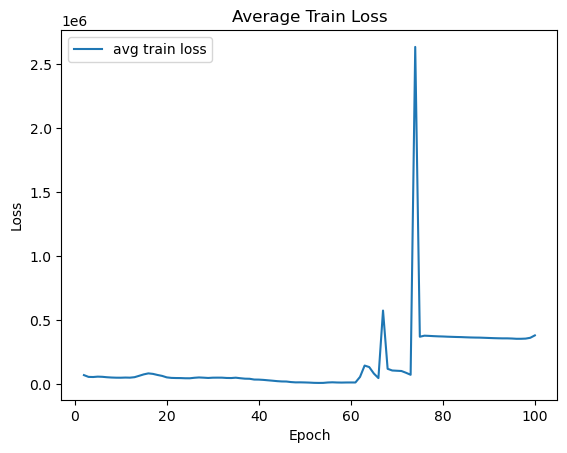

In [25]:
plt.figure()
plt.title("Average Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
x = list(range(1, len(avg_train_losses) + 1))
plt.plot(x[1:200], avg_train_losses[1:200], label="avg train loss")
plt.legend()
plt.show()

## **Train 50 epochs**

In [12]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

BCELoss = torch.nn.BCELoss()

def loss_function(recon_x, x, mu, log_var, beta):
    bce = BCELoss(recon_x, x)
    kld = -0.5 * beta * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return bce, kld  
kernel_size = 3  # Define the kernel size
num_res_units = 2  # Define the number of residual units

# Rest of your code

def train(max_epochs, learning_rate, beta, kernel_size, num_res_units):
    model = VarAutoEncoder(
        spatial_dims=2,
        in_shape=(1, 400, 400),
        out_channels=1,
        latent_size=2,
        channels=(32, 64, 128, 256),
        strides=(1, 2, 2, 2),
        kernel_size=3,
        num_res_units=2
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), learning_rate)

    avg_train_losses = []
    test_losses = []
    avg_bce_losses = []  
    avg_kld_losses = []  

    t = trange(max_epochs, leave=True, desc="epoch 0, average train loss: ?, test loss: ?")
    for epoch in t:
        model.train()
        epoch_loss = 0
        epoch_bce = 0  # Initialize BCE loss accumulator for the epoch
        epoch_kld = 0  # Initialize KLD loss accumulator for the epoch
        num_batches = 0

        for batch_data in train_data_loader:
            rest, motor = batch_data["rest_fMRI_data"].to(device), batch_data["motor_task_fMRI_data"].to(device)
            optimizer.zero_grad()

            recon_batch, mu, log_var, _ = model(motor)
            bce, kld = loss_function(recon_batch, motor, mu, log_var, beta)
            loss = bce + kld  # Total loss
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_bce += bce.item()  # Accumulate BCE loss
            epoch_kld += kld.item()  # Accumulate KLD loss

            num_batches += 1

        avg_epoch_loss = epoch_loss / num_batches
        avg_train_losses.append(avg_epoch_loss)

        # Calculate average BCE and KLD losses for this epoch
        avg_epoch_bce = epoch_bce / num_batches
        avg_epoch_kld = epoch_kld / num_batches
        avg_bce_losses.append(avg_epoch_bce)
        avg_kld_losses.append(avg_epoch_kld)

        model.eval()
        test_loss = 0
        num_batches = 0

        with torch.no_grad():
            for batch_data in test_data_loader:
                rest, motor = batch_data["rest_fMRI_data"].to(device), batch_data["motor_task_fMRI_data"].to(device)
                recon, mu, log_var, _ = model(motor)
                test_loss += loss_function(recon, motor, mu, log_var, beta)[0].item()  # BCE loss only

                num_batches += 1

        avg_test_loss = test_loss / num_batches
        test_losses.append(avg_test_loss)

        model.train()

        t.set_description(
            f"epoch {epoch + 1}, average train loss: {avg_epoch_loss:.4f}, test loss: {avg_test_loss:.4f}"
        )

        # Print BCE, KLD, and total loss for this epoch
        print(f"Epoch {epoch + 1} - BCE: {avg_epoch_bce:.4f}, KLD: {avg_epoch_kld:.4f}, Total Loss: {avg_epoch_loss:.4f}")

    # Calculate the average BCE and KLD losses over all epochs
    avg_bce_loss_over_epochs = sum(avg_bce_losses) / len(avg_bce_losses)
    avg_kld_loss_over_epochs = sum(avg_kld_losses) / len(avg_kld_losses)
    print(f"Average BCE Loss over all epochs: {avg_bce_loss_over_epochs:.4f}")
    print(f"Average KLD Loss over all epochs: {avg_kld_loss_over_epochs:.4f}")

    return model, avg_train_losses, test_losses, recon, recon_batch, motor, avg_bce_loss_over_epochs, avg_kld_loss_over_epochs

max_epochs = 50
learning_rate = 1e-4
beta = 50  # KL beta weighting. Increase for disentangled VAE
latent_size = 2

# Train the model
model, avg_train_losses, test_losses, recon, recon_batch, motor, avg_bce_loss, avg_kld_loss = train(max_epochs, learning_rate, beta, kernel_size, num_res_units)

epoch 1, average train loss: 1898708.0946, test loss: 0.6677:   2%| | 1/50 [00:2

Epoch 1 - BCE: 0.7009, KLD: 1898707.4135, Total Loss: 1898708.0946


epoch 2, average train loss: 69132.6156, test loss: 0.6648:   4%| | 2/50 [00:56<

Epoch 2 - BCE: 0.6651, KLD: 69131.9505, Total Loss: 69132.6156


epoch 3, average train loss: 55228.6921, test loss: 0.6634:   6%| | 3/50 [01:24<

Epoch 3 - BCE: 0.6632, KLD: 55228.0290, Total Loss: 55228.6921


epoch 4, average train loss: 54323.0089, test loss: 0.6621:   8%| | 4/50 [01:52<

Epoch 4 - BCE: 0.6619, KLD: 54322.3469, Total Loss: 54323.0089


epoch 5, average train loss: 57270.8288, test loss: 0.6606:  10%| | 5/50 [02:21<

Epoch 5 - BCE: 0.6604, KLD: 57270.1682, Total Loss: 57270.8288


epoch 6, average train loss: 55939.0462, test loss: 0.6592:  12%| | 6/50 [02:49<

Epoch 6 - BCE: 0.6592, KLD: 55938.3869, Total Loss: 55939.0462


epoch 7, average train loss: 52566.6263, test loss: 0.6578:  14%|▏| 7/50 [03:17<

Epoch 7 - BCE: 0.6578, KLD: 52565.9685, Total Loss: 52566.6263


epoch 8, average train loss: 50316.1217, test loss: 0.6562:  16%|▏| 8/50 [03:45<

Epoch 8 - BCE: 0.6565, KLD: 50315.4653, Total Loss: 50316.1217


epoch 9, average train loss: 49064.7444, test loss: 0.6545:  18%|▏| 9/50 [04:13<

Epoch 9 - BCE: 0.6542, KLD: 49064.0903, Total Loss: 49064.7444


epoch 10, average train loss: 48843.0238, test loss: 0.6507:  20%|▏| 10/50 [04:4

Epoch 10 - BCE: 0.6513, KLD: 48842.3728, Total Loss: 48843.0238


epoch 11, average train loss: 50087.5382, test loss: 0.6483:  22%|▏| 11/50 [05:1

Epoch 11 - BCE: 0.6488, KLD: 50086.8895, Total Loss: 50087.5382


epoch 12, average train loss: 49277.2308, test loss: 0.6465:  24%|▏| 12/50 [05:3

Epoch 12 - BCE: 0.6464, KLD: 49276.5847, Total Loss: 49277.2308


epoch 13, average train loss: 52963.3316, test loss: 0.6448:  26%|▎| 13/50 [06:0

Epoch 13 - BCE: 0.6446, KLD: 52962.6872, Total Loss: 52963.3316


epoch 14, average train loss: 63805.5835, test loss: 0.6430:  28%|▎| 14/50 [06:3

Epoch 14 - BCE: 0.6428, KLD: 63804.9404, Total Loss: 63805.5835


epoch 15, average train loss: 74927.8169, test loss: 0.6416:  30%|▎| 15/50 [07:0

Epoch 15 - BCE: 0.6413, KLD: 74927.1753, Total Loss: 74927.8169


epoch 16, average train loss: 82692.5952, test loss: 0.6400:  32%|▎| 16/50 [07:3

Epoch 16 - BCE: 0.6398, KLD: 82691.9555, Total Loss: 82692.5952


epoch 17, average train loss: 78716.9022, test loss: 0.6386:  34%|▎| 17/50 [07:5

Epoch 17 - BCE: 0.6383, KLD: 78716.2636, Total Loss: 78716.9022


epoch 18, average train loss: 70193.6716, test loss: 0.6373:  36%|▎| 18/50 [08:2

Epoch 18 - BCE: 0.6369, KLD: 70193.0340, Total Loss: 70193.6716


epoch 19, average train loss: 62941.7526, test loss: 0.6358:  38%|▍| 19/50 [08:5

Epoch 19 - BCE: 0.6355, KLD: 62941.1172, Total Loss: 62941.7526


epoch 20, average train loss: 51511.2606, test loss: 0.6340:  40%|▍| 20/50 [09:2

Epoch 20 - BCE: 0.6338, KLD: 51510.6269, Total Loss: 51511.2606


epoch 21, average train loss: 47431.7300, test loss: 0.6318:  42%|▍| 21/50 [09:5

Epoch 21 - BCE: 0.6313, KLD: 47431.0989, Total Loss: 47431.7300


epoch 22, average train loss: 46383.9342, test loss: 0.6293:  44%|▍| 22/50 [10:2

Epoch 22 - BCE: 0.6295, KLD: 46383.3048, Total Loss: 46383.9342


epoch 23, average train loss: 46031.8545, test loss: 0.6273:  46%|▍| 23/50 [10:4

Epoch 23 - BCE: 0.6265, KLD: 46031.2281, Total Loss: 46031.8545


epoch 24, average train loss: 44615.8115, test loss: 0.6256:  48%|▍| 24/50 [11:1

Epoch 24 - BCE: 0.6251, KLD: 44615.1862, Total Loss: 44615.8115


epoch 25, average train loss: 44437.1878, test loss: 0.6243:  50%|▌| 25/50 [11:4

Epoch 25 - BCE: 0.6241, KLD: 44436.5635, Total Loss: 44437.1878


epoch 26, average train loss: 48369.7096, test loss: 0.6226:  52%|▌| 26/50 [12:1

Epoch 26 - BCE: 0.6222, KLD: 48369.0877, Total Loss: 48369.7096


epoch 27, average train loss: 50909.0907, test loss: 0.6212:  54%|▌| 27/50 [12:4

Epoch 27 - BCE: 0.6206, KLD: 50908.4698, Total Loss: 50909.0907


epoch 28, average train loss: 49136.6986, test loss: 0.6205:  56%|▌| 28/50 [13:0

Epoch 28 - BCE: 0.6189, KLD: 49136.0794, Total Loss: 49136.6986


epoch 29, average train loss: 46922.0509, test loss: 0.6195:  58%|▌| 29/50 [13:3

Epoch 29 - BCE: 0.6182, KLD: 46921.4326, Total Loss: 46922.0509


epoch 30, average train loss: 49060.4831, test loss: 0.6184:  60%|▌| 30/50 [14:0

Epoch 30 - BCE: 0.6173, KLD: 49059.8656, Total Loss: 49060.4831


epoch 31, average train loss: 49425.3684, test loss: 0.6177:  62%|▌| 31/50 [14:3

Epoch 31 - BCE: 0.6164, KLD: 49424.7518, Total Loss: 49425.3684


epoch 32, average train loss: 49255.9727, test loss: 0.6168:  64%|▋| 32/50 [15:0

Epoch 32 - BCE: 0.6156, KLD: 49255.3573, Total Loss: 49255.9727


epoch 33, average train loss: 46895.0154, test loss: 0.6162:  66%|▋| 33/50 [15:3

Epoch 33 - BCE: 0.6148, KLD: 46894.4007, Total Loss: 46895.0154


epoch 34, average train loss: 46363.6126, test loss: 0.6154:  68%|▋| 34/50 [15:5

Epoch 34 - BCE: 0.6146, KLD: 46362.9980, Total Loss: 46363.6126


epoch 35, average train loss: 48985.3225, test loss: 0.6147:  70%|▋| 35/50 [16:2

Epoch 35 - BCE: 0.6136, KLD: 48984.7088, Total Loss: 48985.3225


epoch 36, average train loss: 44790.9848, test loss: 0.6140:  72%|▋| 36/50 [16:5

Epoch 36 - BCE: 0.6126, KLD: 44790.3723, Total Loss: 44790.9848


epoch 37, average train loss: 41320.1439, test loss: 0.6134:  74%|▋| 37/50 [17:2

Epoch 37 - BCE: 0.6121, KLD: 41319.5316, Total Loss: 41320.1439


epoch 38, average train loss: 40514.7835, test loss: 0.6127:  76%|▊| 38/50 [17:5

Epoch 38 - BCE: 0.6109, KLD: 40514.1725, Total Loss: 40514.7835


epoch 39, average train loss: 34529.8582, test loss: 0.6120:  78%|▊| 39/50 [18:2

Epoch 39 - BCE: 0.6108, KLD: 34529.2475, Total Loss: 34529.8582


epoch 40, average train loss: 34021.1831, test loss: 0.6115:  80%|▊| 40/50 [18:4

Epoch 40 - BCE: 0.6096, KLD: 34020.5735, Total Loss: 34021.1831


epoch 41, average train loss: 31844.4594, test loss: 0.6110:  82%|▊| 41/50 [19:1

Epoch 41 - BCE: 0.6093, KLD: 31843.8502, Total Loss: 31844.4594


epoch 42, average train loss: 28577.4282, test loss: 0.6105:  84%|▊| 42/50 [19:4

Epoch 42 - BCE: 0.6088, KLD: 28576.8195, Total Loss: 28577.4282


epoch 43, average train loss: 25486.1190, test loss: 0.6099:  86%|▊| 43/50 [20:1

Epoch 43 - BCE: 0.6082, KLD: 25485.5105, Total Loss: 25486.1190


epoch 44, average train loss: 21995.4132, test loss: 0.6092:  88%|▉| 44/50 [20:4

Epoch 44 - BCE: 0.6080, KLD: 21994.8052, Total Loss: 21995.4132


epoch 45, average train loss: 19634.7201, test loss: 0.6086:  90%|▉| 45/50 [21:0

Epoch 45 - BCE: 0.6073, KLD: 19634.1126, Total Loss: 19634.7201


epoch 46, average train loss: 19078.8423, test loss: 0.6080:  92%|▉| 46/50 [21:3

Epoch 46 - BCE: 0.6067, KLD: 19078.2356, Total Loss: 19078.8423


epoch 47, average train loss: 14815.5608, test loss: 0.6075:  94%|▉| 47/50 [22:0

Epoch 47 - BCE: 0.6055, KLD: 14814.9554, Total Loss: 14815.5608


epoch 48, average train loss: 12440.8401, test loss: 0.6069:  96%|▉| 48/50 [22:3

Epoch 48 - BCE: 0.6056, KLD: 12440.2344, Total Loss: 12440.8401


epoch 49, average train loss: 12694.9952, test loss: 0.6065:  98%|▉| 49/50 [23:0

Epoch 49 - BCE: 0.6040, KLD: 12694.3914, Total Loss: 12694.9952


epoch 50, average train loss: 11848.4314, test loss: 0.6057: 100%|█| 50/50 [23:3

Epoch 50 - BCE: 0.6041, KLD: 11847.8273, Total Loss: 11848.4314
Average BCE Loss over all epochs: 0.6294
Average KLD Loss over all epochs: 82725.9328


## **Plot reconstructed FC from test data**

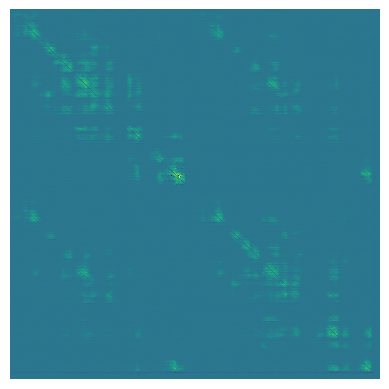

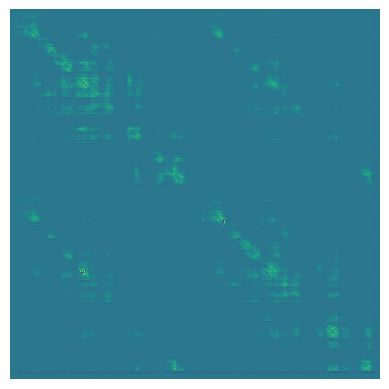

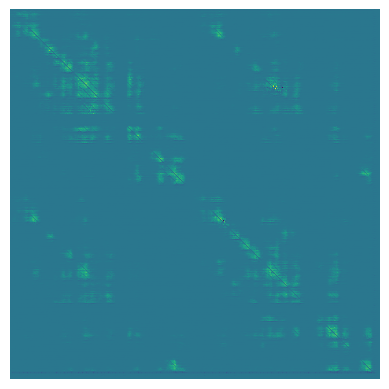

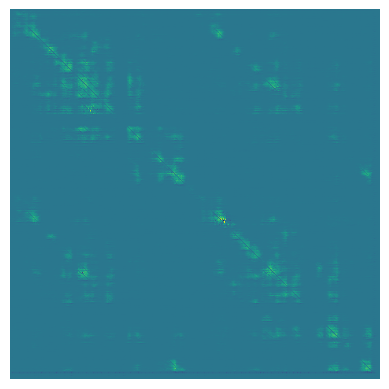

IndexError: index 4 is out of bounds for dimension 0 with size 4

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

for i in range(len(recon)):
    recon_cpu = recon_batch[i][0].detach().cpu().numpy()  
    plt.imshow(recon_cpu, cmap='viridis', interpolation='nearest')
    plt.axis('off')
    plt.show()

In [13]:
# Convert recon_batch_all to a float data type and move to the same device as motor
recon_batch_all = recon_batch.float().to(motor.device)

# Calculate the mean of motor and make sure it's of data type float and on the same device
mean_motor = torch.mean(motor, dim=0, keepdim=True).float().to(motor.device)
mean_motor = mean_motor.expand_as(recon)

# Calculate the MSE loss between recon_batch_all and the mean of motor
mse_loss_mean_motor = torch.nn.MSELoss()(recon, mean_motor)

# Calculate the standard deviation of the mean_motor
std_mean_motor = torch.std(mean_motor)

print("MSE:", mse_loss_mean_motor.item())
print("Std:", std_mean_motor.item())


MSE: 0.04239879548549652
Std: 0.12552838027477264


In [14]:
BCELoss = torch.nn.BCELoss()

# Convert recon_batch_all to a float data type and move to the same device as motor
recon_batch_all = recon_batch.float().to(motor.device)

# Calculate the mean of motor and make sure it's of data type float and on the same device
mean_motor = torch.mean(motor, dim=0, keepdim=True).float().to(motor.device)
mean_motor = mean_motor.expand_as(recon)

# Calculate the BCE loss between recon_batch_all and the mean of motor
bce_loss_mean_motor = BCELoss(recon, mean_motor)

# Calculate the standard deviation of the mean_motor
std_mean_motor = torch.std(mean_motor)

print("BCE:", bce_loss_mean_motor.item())
print("Std:", std_mean_motor.item())

BCE: 0.5974793434143066
Std: 0.12552838027477264


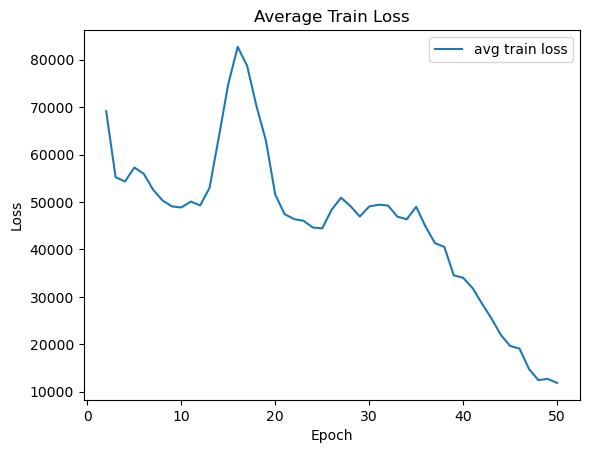

In [15]:
plt.figure()
plt.title("Average Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
x = list(range(1, len(avg_train_losses) + 1))
plt.plot(x[1:200], avg_train_losses[1:200], label="avg train loss")
plt.legend()
plt.show()

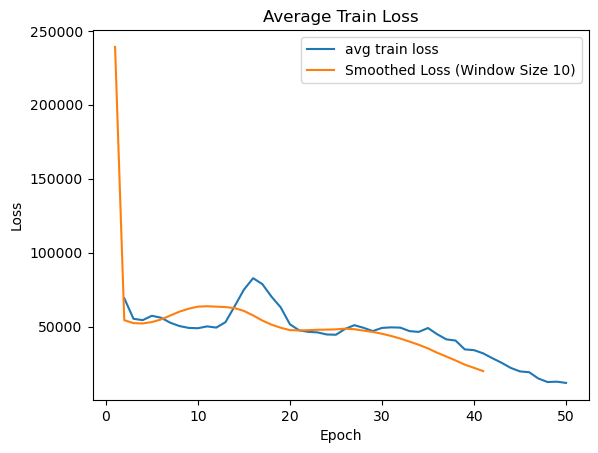

In [18]:
plt.figure()
plt.title("Average Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
x = list(range(1, len(avg_train_losses) + 1))
plt.plot(x[1:200], avg_train_losses[1:200], label="avg train loss")

# Apply smoothing using a rolling mean
window_size = 10  # Adjust the window size for smoothing
smoothed_losses = np.convolve(avg_train_losses, np.ones(window_size)/window_size, mode='valid')
smoothed_x = x[:len(smoothed_losses)]

# Plot the smoothed line
plt.plot(smoothed_x, smoothed_losses, label=f"Smoothed Loss (Window Size {window_size})")

plt.legend()
plt.show()